<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/Proyecto/Adsorcion%20en%20superficies%20basado%20en%20RIUS%20V%201.0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Theoretic Learning for Data Upsampling

![mutualInfor](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*sHASwCjxy-Tsr3eaDTeHXw.png?raw=1)

# [Mutual Information, Entropy, Information](https://medium.com/swlh/a-deep-conceptual-guide-to-mutual-information-a5021031fad0)

$$I(X;Y) = H(X) - H(X|Y) = H(Y) - H(Y|X) = H(X) + H(Y) - H(X,Y) = H(X,Y) - H(X|Y) - H(Y|X)$$


$$H(X) = \mathbb{E}_{p(x)}\{I(p(x))\} = \mathbb{E}_{p(x)}\left\{\log{\left(\frac{1}{p(x)}\right)}\right\} $$

# Principle of Relevant Information

## Information Bottleneck

Find a reduced representation $\tilde{X}$ of $X$ founded on the conditional distribution $p(\tilde{X}|X)$ that preserves the information of $X$ w.r.t. to $Y$:

$$\min_{p(\tilde{X}|X)} I(\tilde{X},X)-\beta I(\tilde{X},Y)$$

$\beta \in \mathbb{R}^+$, $\tilde{X}\in\mathbb{R}^{M \times P}$, ${X}\in\mathbb{R}^{N \times P}$, $M < N$

## Compression/Clustering based on PRI

$$\boxed{\min_{\tilde{X}} H(\tilde{X})+\lambda D(\tilde{X}||X)}$$

$\lambda\in\mathbb{R}^+$


Fixing $H$ as the quadratic Renyi's entropy and $D$ as the Cauchy Swartz divergence:


$H_\alpha(X) = \frac{1}{1-\alpha}\log\left(\int_{x\in X} p^\alpha (x)dx\right)$

$H_2(X) = -\log\left(\int_{x\in X} p^2 (x)dx\right)$


$D_{CS}(f||g) = -\log\left(\frac{\left(\int f(x)g(x)dx\right)^2}{\int f^2(x)dx \int g^2(x)dx}\right)$


$D_{CS}(f||g) = -\log\left(\left(\int f(x)g(x)dx\right)^2\right) + \log\left(\int f^2(x)dx\right) + \log\left(\int g^2(x)dx\right)$

$D_{CS}(f||g) = 2 H_{CS}(f;g)-H_2(f)-H_2(g)$

$H_{CS}(f;g)=-\log\left(\int f(x)g(x)dx\right)$: Cauchy Swartz cross-entropy (NOT JOINT entropy)





## Gaussian Kernel-based pdf Parzen Estimator

https://medium.com/@cagriaydogdu2334/pdf-estimation-with-parzen-window-a32f3bfffd4c

https://milania.de/blog/Introduction_to_kernel_density_estimation_(Parzen_window_method)


Given the set $\{x_n\in\mathbb{R}^P\}_{n=1}^N$

$\hat{p}(x) = \frac{1}{N}\sum_{n=1}^N k(x-x_n;\sigma^2)$

$k(x-x_n;\sigma^2) = \exp\left(\frac{-\|x-x_n\|_2^2}{2\sigma^2}\right)$

$\hat{H}_2(X)=-\log\left(\int \hat{p}^2(x) dx \right)= -\log\left(\int \hat{p}(x) \hat{p}(x)dx\right) = -\log\left(\int \frac{1}{N}\sum_{n=1}^N k(x-x_n;\sigma^2)\frac{1}{N}\sum_{m=1}^N k(x-x_m;\sigma^2) dx\right)$

Applying convolution property for Gaussian functions:

http://www.lucamartino.altervista.org/2003-003.pdf

$\boxed{\hat{H}_2(X)= -\log\left(\frac{1}{N^2}\sum_{n=1}^N\sum_{m=1}^N k(x_n-x_m;2\sigma^2)\right)}$

Now, for $\{x_n\in\mathbb{R}^P\}_{n=1}^N$ (realted to $f(x)$) and $\{x_m\in\mathbb{R}^P\}_{m=1}^M$ (related to $g(x)$):

$\hat{H}_{CS}(f;g)=-\log\left(\int \hat{f}(x)\hat{g}(x) dx \right) = -\log\left(\int \frac{1}{N}\sum_{n=1}^N k(x-x_n;\sigma^2)\frac{1}{M}\sum_{m=1}^M k(x-x_m;\sigma^2) dx\right)$


$\boxed{\hat{H}_{CS}(f;g)= -\log\left(\frac{1}{NM}\sum_{n=1}^N\sum_{m=1}^M k(x_n-x_m;2\sigma^2)\right)}$


Then:


$$\min_{\hat{X}} H_2(\tilde{X})+\lambda D_{CS}(\tilde{X}||X) = H_2(\tilde{X})+\lambda\left(2 H_{CS}(\tilde{X};X)-H_2(\tilde{X})-H_2(X)\right) $$

$$\min_{\hat{X}} H_2(\tilde{X})+\lambda D_{CS}(\tilde{X}||X) = H_2(\tilde{X})+2 \lambda H_{CS}(\tilde{X};X)-\lambda H_2(\tilde{X})-\lambda H_2(X) $$


$$\min_{\hat{X}} (1-\lambda)H_2(\tilde{X})+2\lambda H_{CS}(\tilde{X};X)-\lambda H_2(X) $$

$-\lambda H_2(X)$: constant w.r.t. $\tilde{X}$

PRI aims to minimize:


$$\boxed{\min_{\hat{X}} (1-\lambda)H_2(\tilde{X})+2\lambda H_{CS}(\tilde{X};X)} $$

Applying Gaussian kernel-based parzen windows estimations:


$$\min_{\hat{X}} (1-\lambda)\hat{H}_2(\tilde{X})+2\lambda \hat{H}_{CS}(\tilde{X};X)$$

$$\min_{\hat{X}} (1-\lambda)\left(-\log\left(\frac{1}{M^2}\sum_{m=1}^M\sum_{m'=1}^M k(\tilde{x}_m-\tilde{x}_{m'};2\sigma^2)\right)\right)+2\lambda\left(-\log\left(\frac{1}{MN}\sum_{m=1}^M\sum_{n=1}^N k(\tilde{x}_m-x_n;2\sigma^2)\right)\right)$$


$\tilde{x}_m,\tilde{x}_{m'} \in \tilde{X}$, $x_n \in X$

## PRI Matrix Form

$$\boxed{\min_{\hat{X}} (1-\lambda)\left(-\log\left(\frac{1}{M^2}1_M^\top K_{\tilde{X},\tilde{X}} 1_M\right)\right)+2\lambda\left(-\log\left(\frac{1}{MN}1_M^\top K_{\tilde{X},{X}} 1_N\right)\right)}$$

$K_{\tilde{X},{X}}=[k(\tilde{x}_m-x_n;2\sigma^2)]$

$K_{\tilde{X},\tilde{X}}\in [0,1]^{M\times M},$ $K_{\tilde{X},{X}}\in [0,1]^{M\times N}$

$1_M$: all-ones column vector of size M.


## [Matrix-based Renyi's Entropy](https://arxiv.org/abs/1211.2459)

$S_\alpha(A) = \frac{1}{1-\alpha}\log\left(tr(A^\alpha)\right)$

$tr(A) = 1$

$S_\alpha(A,B) = S_\alpha\left(\frac{A \circ B}{tr(A \circ B)}\right) $

$A,B \succ 0;$ kernel matrices - gramm matrices

$$I_\alpha(X;\hat{X}) = S_\alpha(X) + S_\alpha(\hat{X}) - S_\alpha(X,\hat{X}) $$

$X \in \mathbb{R}^{N \times P}$; $\hat{X}\in \mathbb{R}^{M \times P}$; $M < N$


$S_\alpha(X)$ constant

$$\tilde{I}_\alpha(X;\hat{X}|\lambda) = (1-\lambda)S_\alpha(\hat{X}) - \lambda S_\alpha(X,\hat{X}) $$

$\lambda \in [0,1]$


to think about it...

In [ ]:
pip install requests Pillow

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# URL of the image
#image_url = 'https://a.storyblok.com/f/178900/640x360/776e917b43/3c62998ad933b2615c621eb613a9e99a1682968311_main.jpg/m/filters:quality(95)format(webp)'
image_url = 'https://static.wikia.nocookie.net/dragonball/images/2/2e/Goku_Joven_Flashback.jpg/revision/latest?cb=20170809015919&path-prefix=es'
# Send a GET request to the image URL
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image
    image = Image.open(BytesIO(response.content))

    # Display the image (if you're running this in a Jupyter notebook or similar environment)


    # You can now use the 'image' object for further processing
else:
    print("Failed to retrieve the image. Status code:", response.status_code)


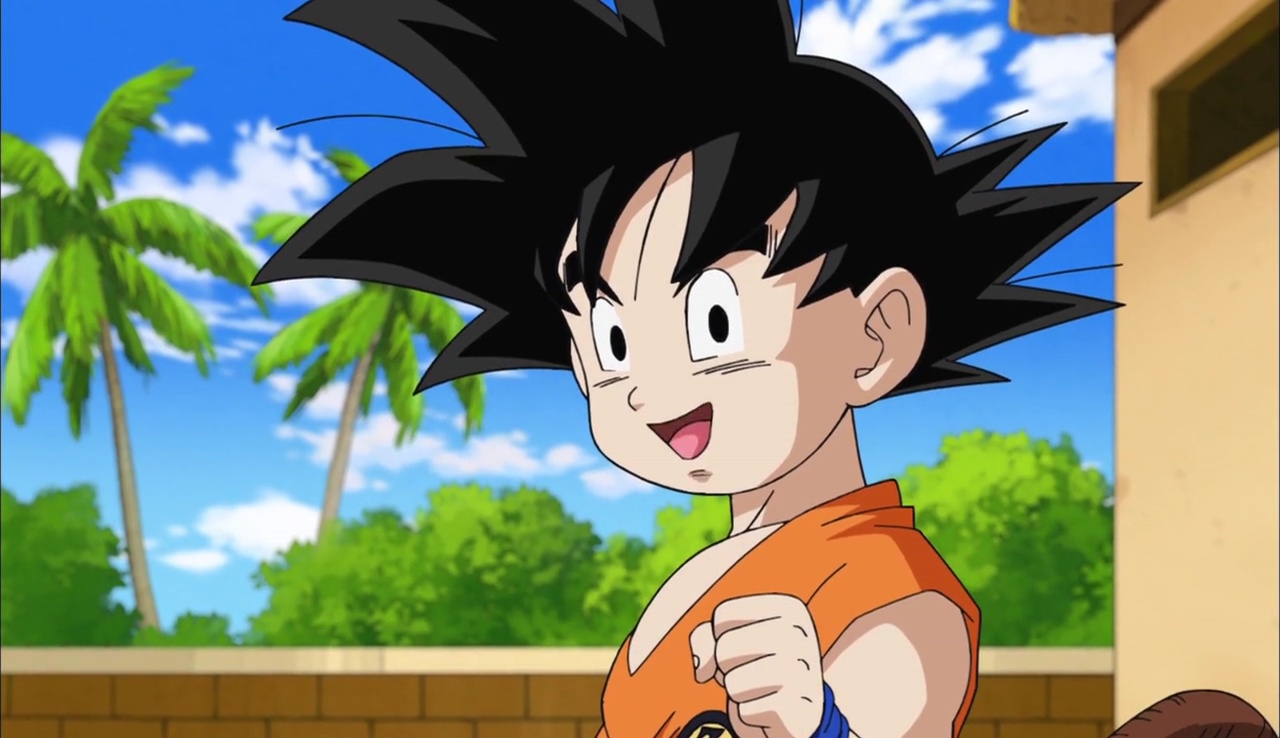

In [ ]:
image

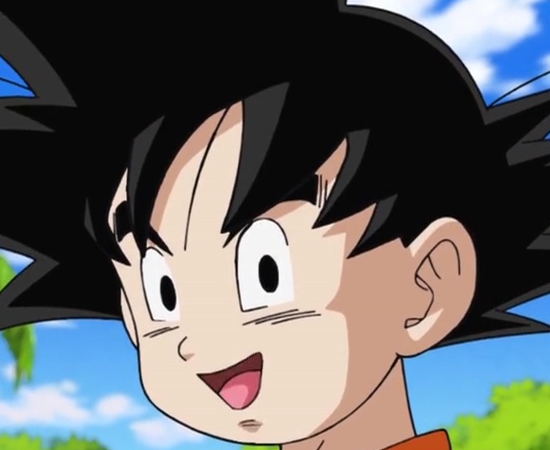

In [ ]:
image_c = image.crop((450,50,1000,500))
image_c

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
image_n = np.array(image_c)

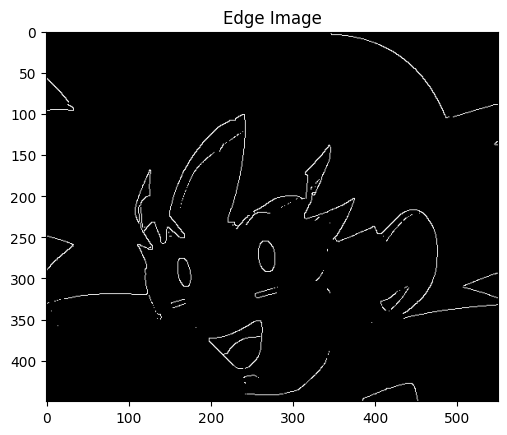

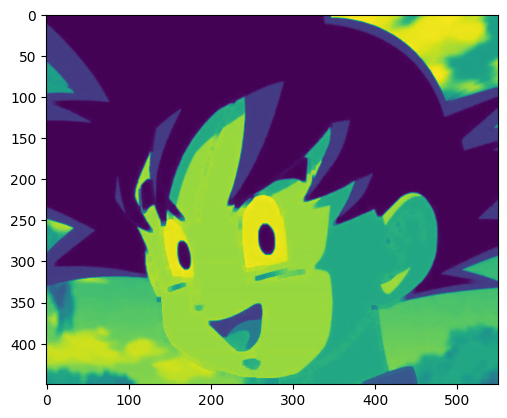

In [ ]:
# Convert the image to grayscale, as Canny edge detection requires grayscale images
gray_image = cv2.cvtColor(image_n, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5, 5), np.uint8)

gray_image = cv2.dilate(gray_image, kernel, iterations=1)
gray_image = cv2.erode(gray_image, kernel,  iterations=1)

# Apply Canny edge detection
# The arguments are the input image, and two thresholds: low and high
# Play with these values to find the edges as per your requirement
edges = cv2.Canny(gray_image, 225, 225)



plt.imshow(edges, cmap='gray')
plt.title('Edge Image')
plt.show()
plt.imshow(gray_image)
plt.show()


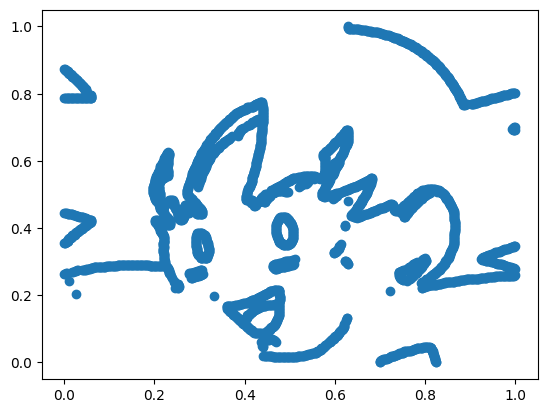

(3627, 2) 3627


In [ ]:
from sklearn.preprocessing import MinMaxScaler
ths = 250
y_, x_ = np.where(edges > ths)


X = np.c_[x_,edges.shape[0]-y_]
X = MinMaxScaler().fit_transform(X)
#X = X[::5]
plt.scatter(X[:,0],X[:,1])
plt.show()
print(X.shape,(edges>ths).sum())

# Exponential Quadratic kernel

$ \kappa(x, y) = \varsigma^2 \exp\left(-\frac{\|x - y\|^2_2}{2 \sigma^2}\right) $

For simplicity: $\varsigma = 1$

# Parzen pdf estimation

$\hat{p}(x) = \frac{1}{N}\sum_{n=1}^N \kappa(x, x_n)$

$\kappa(x, y)\in[0,1]$



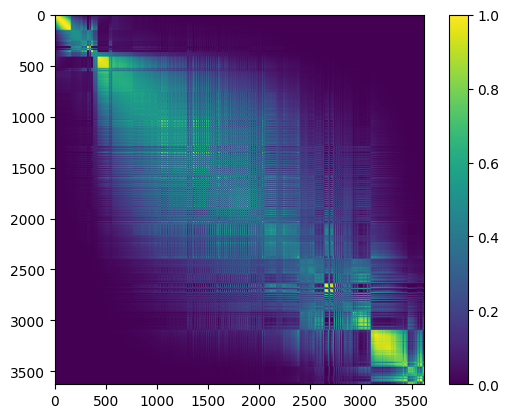

In [ ]:
length_scale = 0.15
ker = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=length_scale)
Kx = ker.matrix(X, X)
plt.imshow(Kx.numpy())
plt.colorbar()
plt.show()

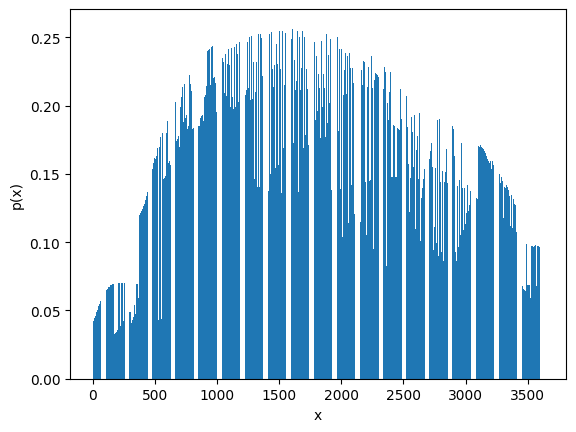

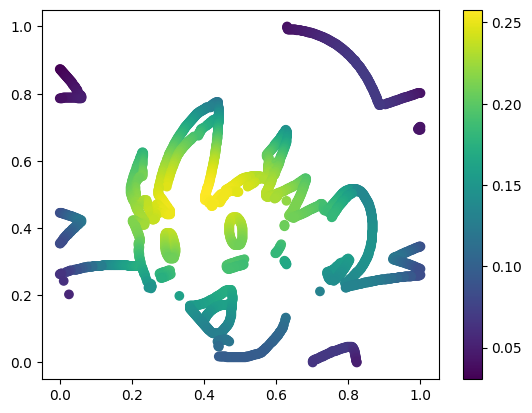

In [ ]:
px = (1/X.shape[0])*Kx.numpy().dot(np.ones((X.shape[0],1))).ravel()
plt.bar(np.arange(0,X.shape[0]),px)
plt.ylabel('p(x)')
plt.xlabel('x')
plt.show()

plt.scatter(X[:,0],X[:,1],c = px)
plt.colorbar()
plt.show()

# Matrix-based Renyi's Entropy Principle Relevant Information



In [ ]:
#uniform init
def PRI_init(X,M,por_=0.05):
    xmin_values = tf.constant(list(X.min(axis=0)-por_*X.max(axis=0)),dtype = "float32")
    xmax_values = tf.constant(list(X.max(axis=0)+por_*X.max(axis=0)),dtype = "float32")

    rows = M
    cols = X.shape[1]  # Number of columns

    random_tensor_scaled = tf.math.multiply(tf.random.uniform(shape=(rows, cols), minval=0, maxval=1),
                                            tf.repeat(tf.transpose(xmax_values[:, tf.newaxis] - xmin_values[:, tf.newaxis]),rows,axis=0))

    # Add the minimum values to each row
    return random_tensor_scaled +  tf.repeat(tf.transpose(xmin_values[:, tf.newaxis]),rows,axis=0)

Xh = PRI_init(X,M=300,por_=0.05)
Xh.shape

TensorShape([300, 2])

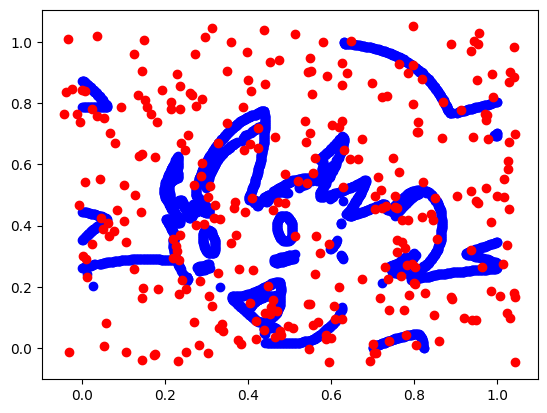

In [ ]:
Xh_ =  Xh.numpy()
plt.scatter(X[:,0],X[:,1],c = 'b')
plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r')

plt.show()


## PRI Matrix Form

$$\boxed{\min_{\hat{X}} (1-\lambda)\left(-\log\left(\frac{1}{M^2}1_M^\top K_{\tilde{X},\tilde{X}} 1_M\right)\right)+2\lambda\left(-\log\left(\frac{1}{MN}1_M^\top K_{\tilde{X},{X}} 1_N\right)\right)}$$

In [ ]:
@tf.function
def pri_loss(Xh,Xt,ker,lam_):
  Khh = ker.matrix(Xh, Xh)
  Khx = ker.matrix(Xh, Xt)
  return (1.0-lam_)*(-tf.math.log(tf.math.reduce_mean(Khh)))+(2.0*lam_)*(-tf.math.log(tf.math.reduce_mean(Khx)))

In [ ]:
#tensorflow data
M = 500
Xh = PRI_init(X,M=M,por_=0.025)
Xt = tf.convert_to_tensor(X,dtype=tf.float32)
lam_ = 0.95
lam_ = tf.constant(lam_,dtype=tf.float32)

#kernel
length_scale = 0.05
ker = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=length_scale)

In [ ]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

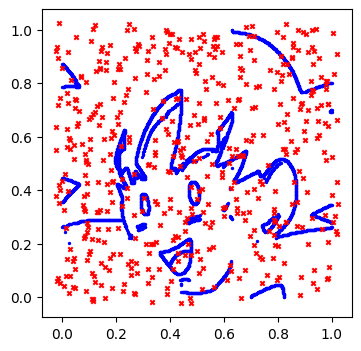

Epoch 1/50
Loss: 7.494386196136475 MeanGrad: [-0.00358415  0.00343571]


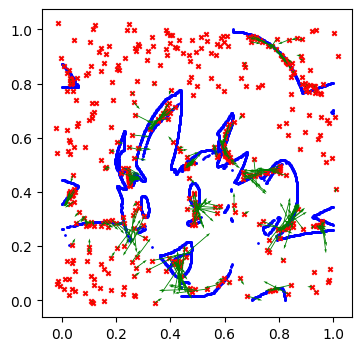

Epoch 2/50
Loss: 7.095580577850342 MeanGrad: [-0.00597081 -0.0028026 ]


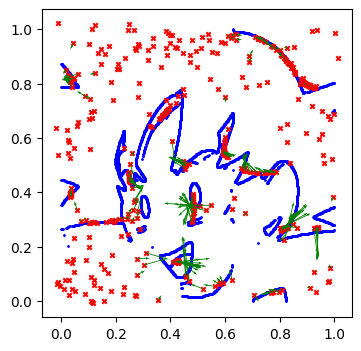

Epoch 3/50
Loss: 6.999582290649414 MeanGrad: [-0.00361366  0.00387911]


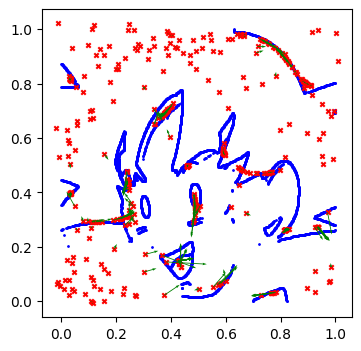

Epoch 4/50
Loss: 7.249373435974121 MeanGrad: [ 0.00621389 -0.00078743]


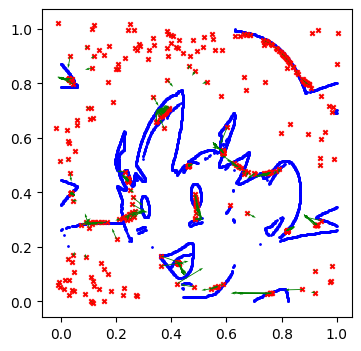

Epoch 5/50
Loss: 6.416190147399902 MeanGrad: [-0.01274976  0.00711163]


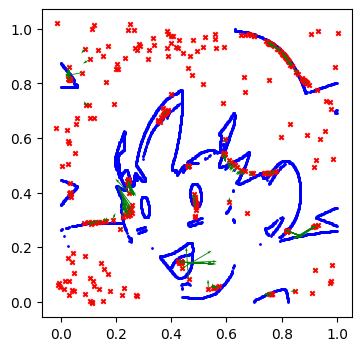

Epoch 6/50
Loss: 6.851135730743408 MeanGrad: [0.01087617 0.00934428]


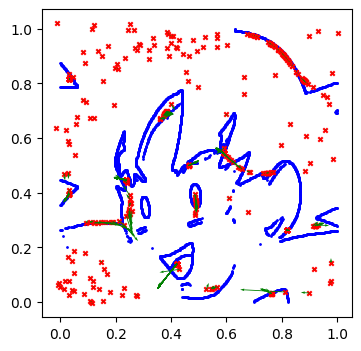

Epoch 7/50
Loss: 6.933991432189941 MeanGrad: [0.00451072 0.0008998 ]


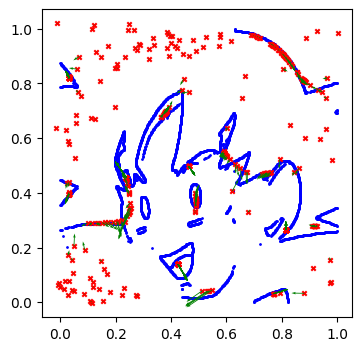

Epoch 8/50
Loss: 6.829292297363281 MeanGrad: [-0.00019028  0.00821514]


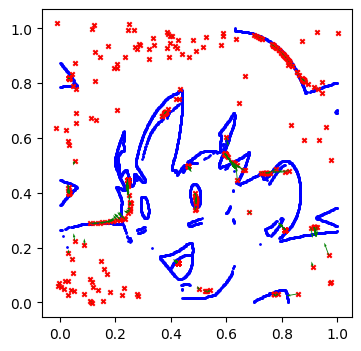

Epoch 9/50
Loss: 7.2040863037109375 MeanGrad: [0.00191237 0.00169952]


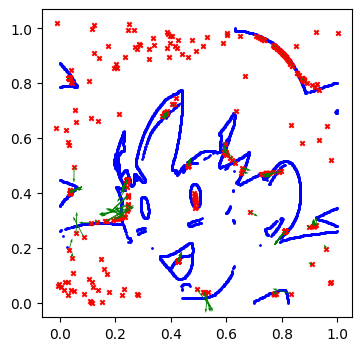

Epoch 10/50
Loss: 6.577544212341309 MeanGrad: [ 0.00399372 -0.00447502]


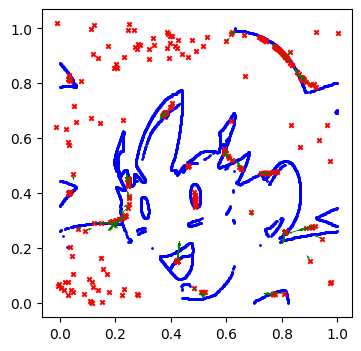

Epoch 11/50
Loss: 6.712582588195801 MeanGrad: [-0.00275906  0.0127449 ]


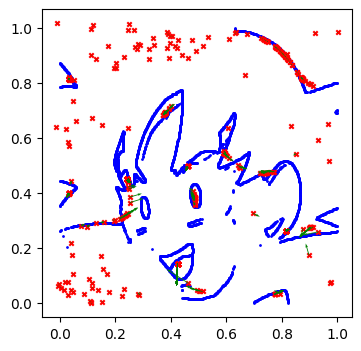

Epoch 12/50
Loss: 7.075253963470459 MeanGrad: [0.00739117 0.00246756]


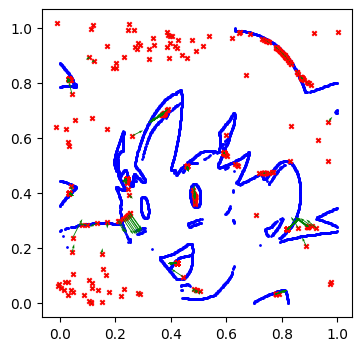

Epoch 13/50
Loss: 7.1627607345581055 MeanGrad: [-0.00113965  0.00412825]


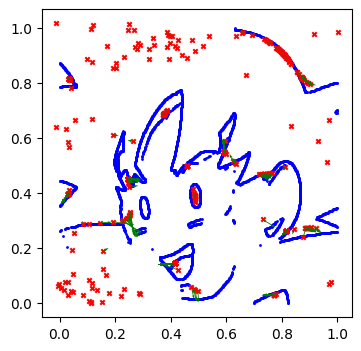

Epoch 14/50
Loss: 6.726676940917969 MeanGrad: [-0.00157167 -0.00719546]


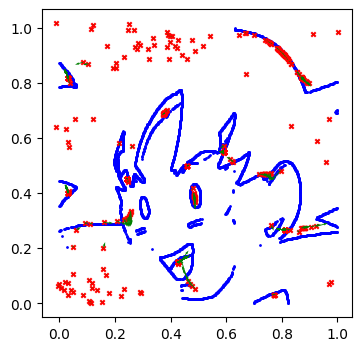

Epoch 15/50
Loss: 6.96676778793335 MeanGrad: [0.00539474 0.00220103]


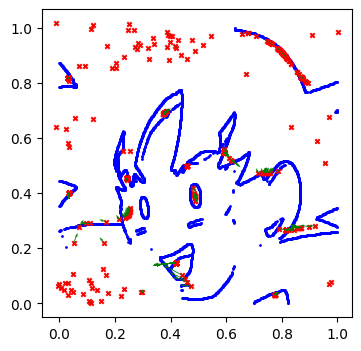

Epoch 16/50
Loss: 6.862343788146973 MeanGrad: [0.00588763 0.00629036]


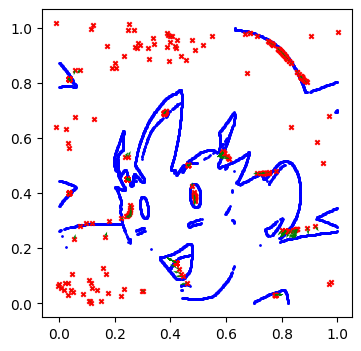

Epoch 17/50
Loss: 6.957839488983154 MeanGrad: [0.00482635 0.0161916 ]


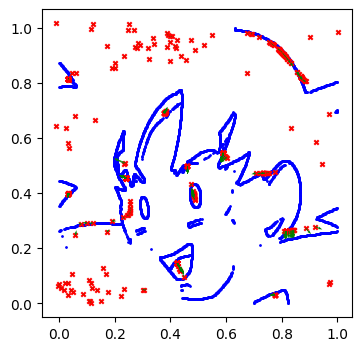

Epoch 18/50
Loss: 6.446987152099609 MeanGrad: [-0.00268655 -0.00340244]


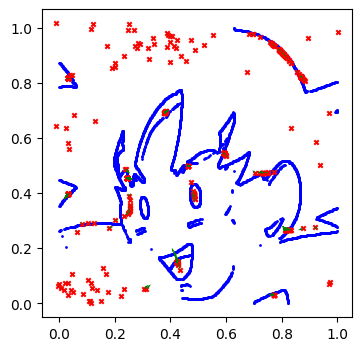

Epoch 19/50
Loss: 6.440818786621094 MeanGrad: [0.00293813 0.0104114 ]


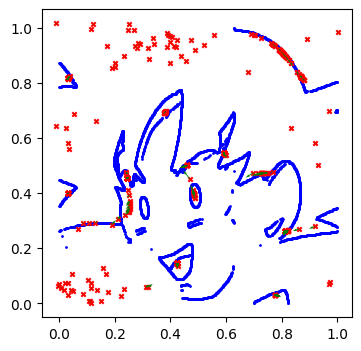

Epoch 20/50
Loss: 6.4652814865112305 MeanGrad: [-1.4892214e-02 -7.3256662e-05]


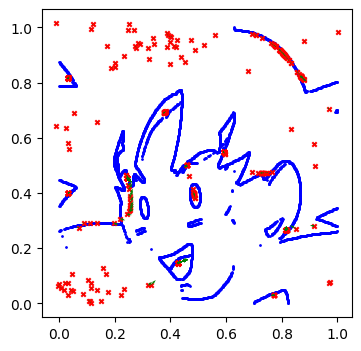

Epoch 21/50
Loss: 6.751189708709717 MeanGrad: [ 0.00352784 -0.00401535]


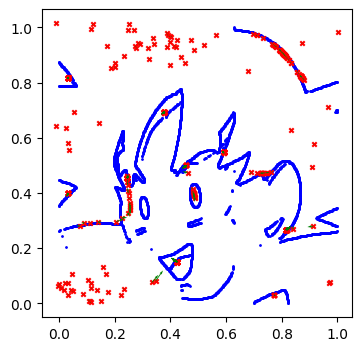

Epoch 22/50
Loss: 6.43496036529541 MeanGrad: [ 0.01161935 -0.00203872]


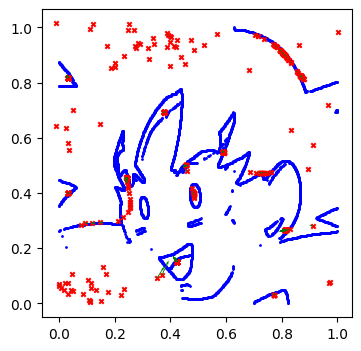

Epoch 23/50
Loss: 6.804380416870117 MeanGrad: [-0.00272913  0.01252544]


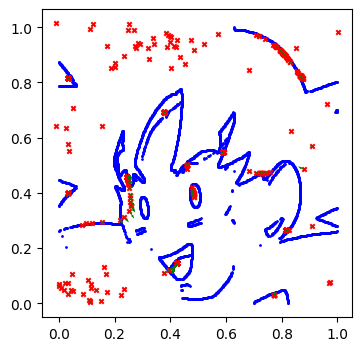

Epoch 24/50
Loss: 6.56679630279541 MeanGrad: [0.00897095 0.00796752]


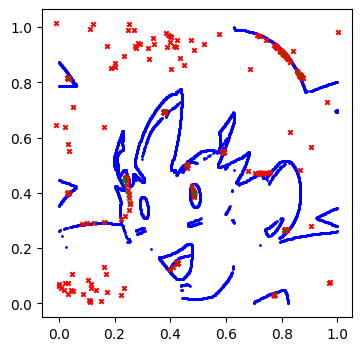

Epoch 25/50
Loss: 6.956971168518066 MeanGrad: [0.00753834 0.00372286]


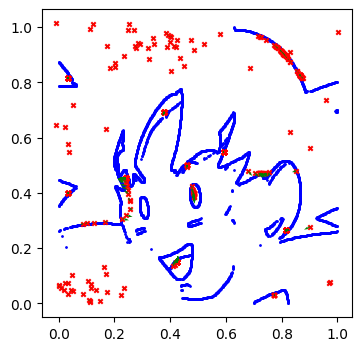

Epoch 26/50
Loss: 6.256828308105469 MeanGrad: [0.00653515 0.00211668]


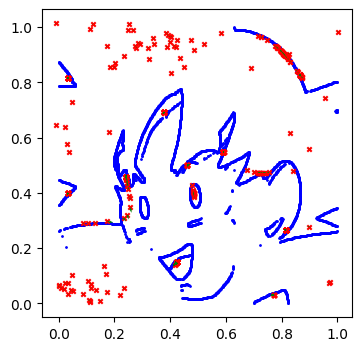

Epoch 27/50
Loss: 6.421416282653809 MeanGrad: [-0.00745682  0.02026576]


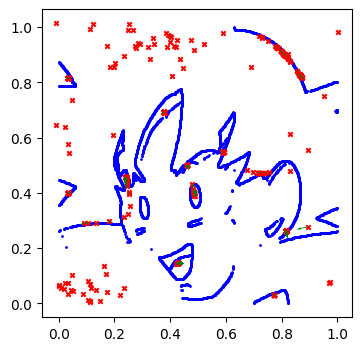

Epoch 28/50
Loss: 7.199644088745117 MeanGrad: [-0.00467289  0.0007279 ]


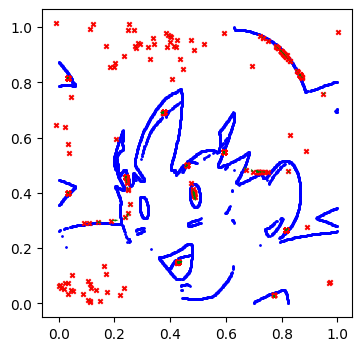

Epoch 29/50
Loss: 7.5098466873168945 MeanGrad: [0.00707007 0.00065508]


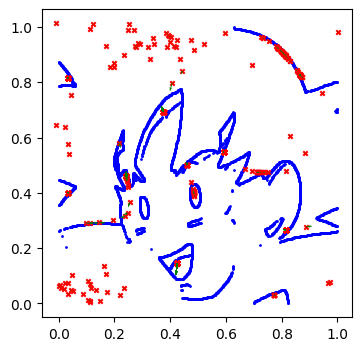

Epoch 30/50
Loss: 6.677062511444092 MeanGrad: [0.00040654 0.01167167]


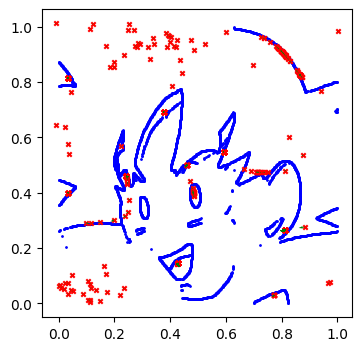

Epoch 31/50
Loss: 6.827775001525879 MeanGrad: [0.01451353 0.01917236]


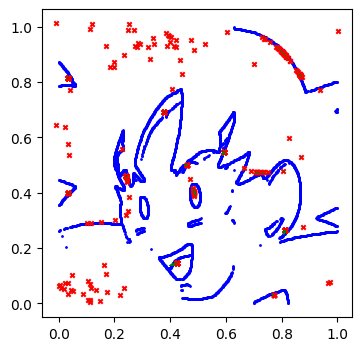

Epoch 32/50
Loss: 6.9419732093811035 MeanGrad: [-0.00037856 -0.00539936]


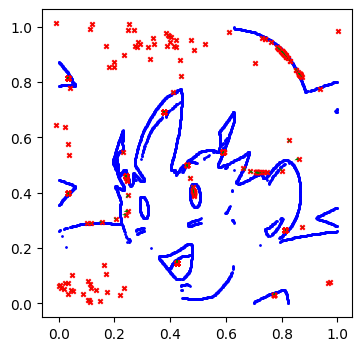

Epoch 33/50
Loss: 6.984941005706787 MeanGrad: [ 0.00097919 -0.00182078]


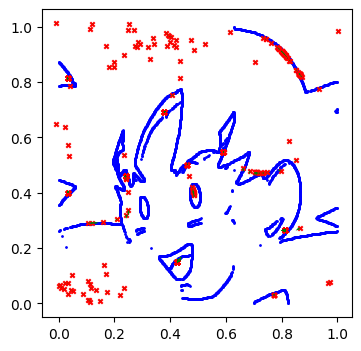

Epoch 34/50
Loss: 6.698559761047363 MeanGrad: [-0.00042279  0.00628898]


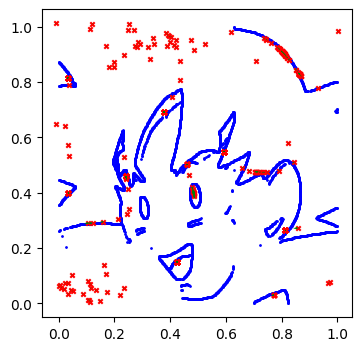

Epoch 35/50
Loss: 6.901261329650879 MeanGrad: [-0.00326494  0.00989969]


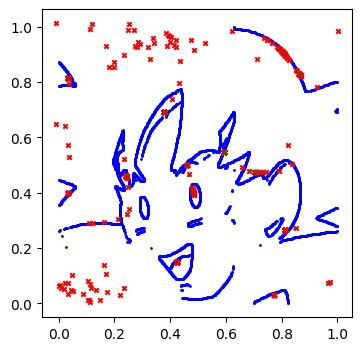

Epoch 36/50
Loss: 6.5742878913879395 MeanGrad: [-0.01474234 -0.00737349]


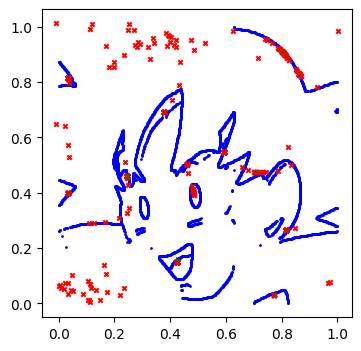

Epoch 37/50
Loss: 7.454134464263916 MeanGrad: [-0.01536981  0.01173177]


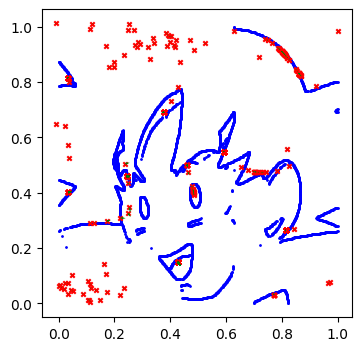

Epoch 38/50
Loss: 6.879581451416016 MeanGrad: [0.0138809  0.00392159]


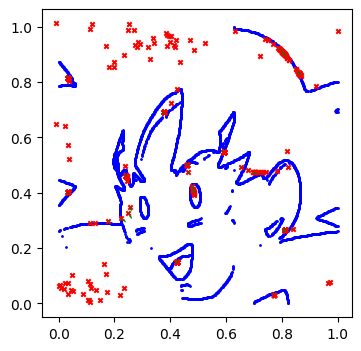

Epoch 39/50
Loss: 6.338590621948242 MeanGrad: [0.0012686  0.00455694]


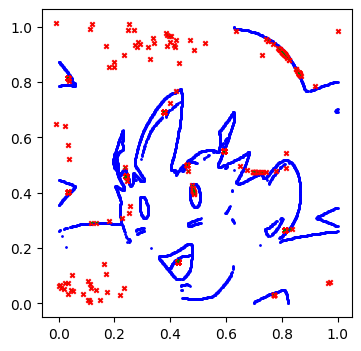

Epoch 40/50
Loss: 6.523568153381348 MeanGrad: [0.00816706 0.01738507]


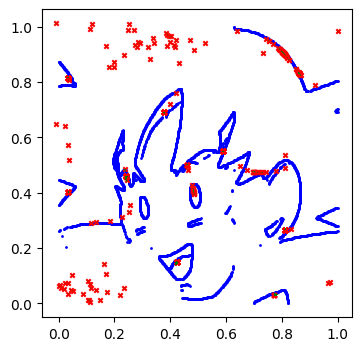

Epoch 41/50
Loss: 6.689697742462158 MeanGrad: [-0.00503562  0.01222013]


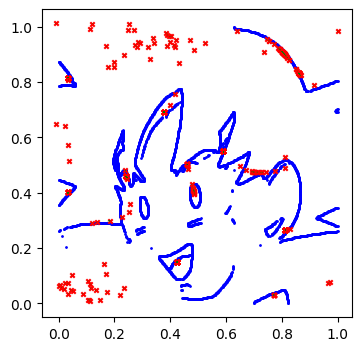

Epoch 42/50
Loss: 6.743032932281494 MeanGrad: [0.00311581 0.00811667]


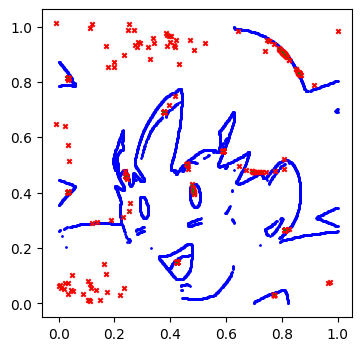

Epoch 43/50
Loss: 6.600086688995361 MeanGrad: [-0.00411683  0.00194246]


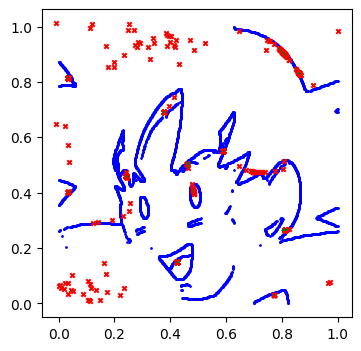

Epoch 44/50
Loss: 6.904537200927734 MeanGrad: [0.01213133 0.01937124]


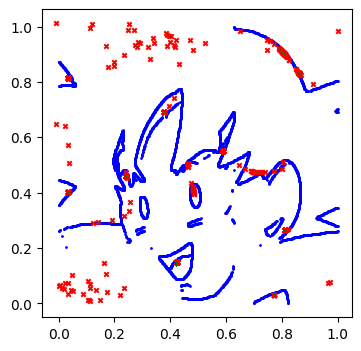

Epoch 45/50
Loss: 6.661766529083252 MeanGrad: [-0.00135956 -0.00601106]


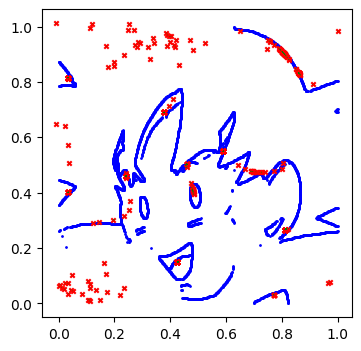

Epoch 46/50
Loss: 6.888528823852539 MeanGrad: [-0.00509888  0.02726409]


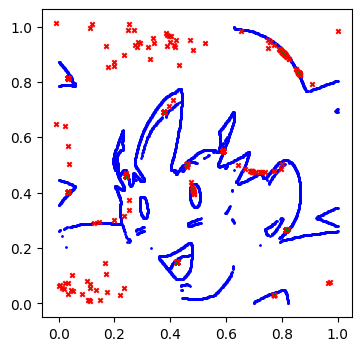

Epoch 47/50
Loss: 6.554551124572754 MeanGrad: [-0.00369021 -0.00232552]


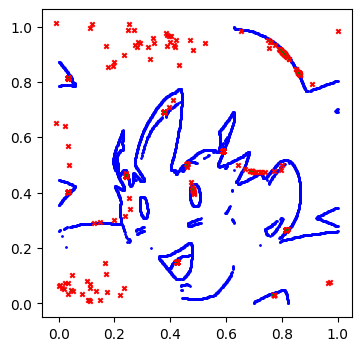

Epoch 48/50
Loss: 6.71237850189209 MeanGrad: [0.00281014 0.00559289]


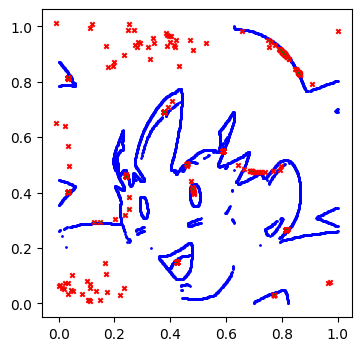

Epoch 49/50
Loss: 6.675878047943115 MeanGrad: [-0.00870853  0.00390617]


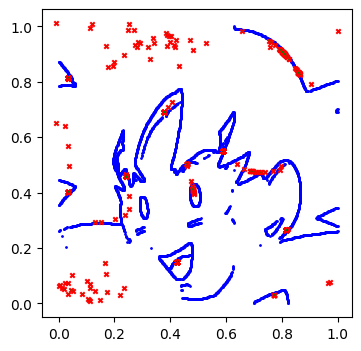

Epoch 50/50
Loss: 6.871188640594482 MeanGrad: [0.00131903 0.01533126]


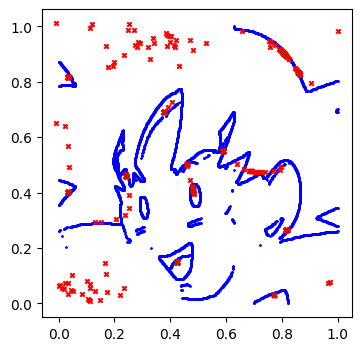

In [ ]:
Xh_ =  Xh.numpy()
plt.figure(figsize=(4,4))
plt.scatter(X[:,0],X[:,1],c = 'b',s=2)
plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
plt.show()
# Custom training loop
eta0 = 1e-1
batch_size = 256
epochs = 50
decay_rate = 0.95

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    for x_batch in tf.data.Dataset.from_tensor_slices(Xt).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(Xh)
        pri_loss_ = pri_loss(Xh,x_batch,ker,lam_)
      grad_ = g.gradient(pri_loss_, Xh)
      Xh = Xh -eta*grad_
    print(f'Loss: {pri_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    Xh_ =  Xh.numpy()
    gradN = -10*eta*grad_.numpy()


    plt.figure(figsize=(4,4))
    plt.scatter(X[:,0],X[:,1],c = 'b',s=1)
    plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
    plt.quiver(Xh_[:,0],Xh_[:,1], gradN[:,0], gradN[:,1], color='g', scale=1, scale_units='xy', angles='xy', label='Gradient Vectors')
    plt.show()

# Tareas Luker - Sofia y Juan Lugo


## Unsupervised Deep Embedding for Clustering Analysis

https://proceedings.mlr.press/v48/xieb16.pdf

https://github.com/HaebinShin/dec-tensorflow


## Tareas Sofia:

Revisar matemática PRI

Revisar Paper Unsupervised Deep Embedding for Clustering Analysis

Implementar DEC según github compartido y aplicar sobre experimento de goku y sobre Fashion Mnist

## Tareas Juan Lugo

Revisar modelo tabnet

https://paperswithcode.com/method/tabnet

Revisar implementaciones sobre keras

https://github.com/jeyabbalas/tabnet

Aplicar sobre base de datos fifa19 curso aprendizaje de máquina para luego aplicar a Luker

## Objetivo luker

- Unir DCE/PRI sofia con Tabnet Lugo, con modelo generativo para lidear con generación de propiedades físico químicas desde espacio latente anotadores

## Tareas sofia y lugo

Revisar focal loss para lidear con datos desbalanceados

https://paperswithcode.com/method/focal-loss